In [1]:
import requests
import yfinance as yf
import pandas as pd
import plotly.graph_objects as go

pd.set_option('display.max_rows', None)

%matplotlib inline

In [2]:
MULTIPLIER = 3
ROLLING_PERIOD=10

In [3]:
def generate_super_trend_for_ticker(symbol, start_date='2000-01-01', end_date='2022-08-30'):
    ticker_data = yf.Ticker(symbol).history(period="max")
    ticker_data = ticker_data.loc[start_date:end_date]
    
    # calculate high low 
    ticker_data = generate_average_true_range(ticker_data, ROLLING_PERIOD)
    ticker_data = generate_basic_bands(ticker_data, MULTIPLIER)
    ticker_data = generate_final_bands(ticker_data, ROLLING_PERIOD)
    
    return ticker_data

In [4]:
def generate_average_true_range(ticker_data, rolling_period=14):
    
    # calculate high - low difference
    ticker_data['high-low'] = ticker_data['High'] - ticker_data['Low']
    
    # calculate high - previous close 
    ticker_data['Previous Close'] = ticker_data['Close'].shift(1)
    ticker_data['high-previous_close'] = ticker_data['High'] - ticker_data['Previous Close']
    
    # calculate low - previous close
    ticker_data['low-previous_close'] = ticker_data['Low'] - ticker_data['Previous Close']
    
    # calculate true range
    ticker_data['true_range'] = ticker_data[['high-low', 'high-previous_close', 'low-previous_close']].max(axis=1)
    
    # calculate average true range
    ticker_data['average_true_range'] = ticker_data['true_range'].rolling(window=rolling_period).mean()
    
    return ticker_data

In [5]:
def generate_basic_bands(ticker_data, multiplier):
    ticker_data['high_low_avg'] = (ticker_data['High'] + ticker_data['Low']) / 2
    ticker_data['lower_band'] = ticker_data['high_low_avg'] - (multiplier * ticker_data['average_true_range'])
    ticker_data['higher_band'] = ticker_data['high_low_avg'] + (multiplier * ticker_data['average_true_range'])
    
    return ticker_data

In [6]:
def generate_final_bands(ticker_data, rolling_period):
    # initialization values 
    start_index = rolling_period
    
    final_upper_band = [ticker_data.iloc[i]['higher_band'] for i in range(0, start_index)]
    final_lower_band = [ticker_data.iloc[i]['lower_band'] for i in range(0, start_index)]
    super_trend = [ticker_data.iloc[i]['higher_band'] for i in range(0, start_index)]
    
    buy_or_sell = [None for i in range(0, start_index)]
    
    for i in range(start_index, len(ticker_data.index)):
        current = i
        previous = i - 1

        current_basic_upper_band = ticker_data.iloc[current]['higher_band']
        current_basic_lower_band = ticker_data.iloc[current]['lower_band']
        current_close = ticker_data.iloc[current]['Close']

        previous_final_upper_band = final_upper_band[-1]
        previous_final_lower_band = final_lower_band[-1]
        previous_super_trend = super_trend[-1]
        previous_close = ticker_data.iloc[previous]['Close']

        if current_basic_upper_band < previous_final_upper_band or previous_close > previous_final_upper_band:
            final_upper_band.append(current_basic_upper_band)
        else:
            final_upper_band.append(previous_final_upper_band)


        if current_basic_lower_band > previous_final_lower_band or previous_close < previous_final_lower_band:
            final_lower_band.append(current_basic_lower_band)
        else:
            final_lower_band.append(previous_final_lower_band)


        current_final_upper_band = final_upper_band[-1]
        current_final_lower_band = final_lower_band[-1]

        if previous_super_trend == previous_final_upper_band and current_close < current_final_upper_band:
            buy_or_sell.append(False)
            super_trend.append(current_final_upper_band)

        elif previous_super_trend == previous_final_upper_band and current_close > current_final_upper_band:
            buy_or_sell.append(True)
            super_trend.append(current_final_lower_band)

        elif previous_super_trend == previous_final_lower_band and current_close > current_final_lower_band:
            buy_or_sell.append(True)
            super_trend.append(current_final_lower_band)

        elif previous_super_trend == previous_final_lower_band and current_close < current_final_lower_band:
            buy_or_sell.append(False)
            super_trend.append(current_final_upper_band)

    ticker_data['super_trend'] = super_trend
    ticker_data['final_higher_band'] = final_upper_band
    ticker_data['final_lower_band'] = final_lower_band
    ticker_data['buy_or_sell'] = buy_or_sell
    
    ticker_data = ticker_data.iloc[1:]
    return ticker_data

In [7]:
def chart_super_trend(super_trend_df):
    # get buy/sell lines 
    buys_line = []
    sells_line = []

    for i in range(0, len(super_trend_df.index)):
        value = super_trend_df.iloc[i]['super_trend']
        if super_trend_df.iloc[i]['buy_or_sell']:
            buys_line.append(value)
            sells_line.append(None)
        else:
            sells_line.append(value)
            buys_line.append(None)
        
    # extract data for candles
    candlestick = go.Candlestick(
        name='candles',
        x=super_trend_df.index,
        open=super_trend_df['Open'],
        high=super_trend_df['High'],
        low=super_trend_df['Low'],
        close=super_trend_df['Close']
    )

    # extract data for lower & higher bands
    lower_band = go.Line(
        name='lower_band',
        x=super_trend_df.index,
        y=super_trend_df['lower_band'],
        line=dict(color="purple"),
    )

    higher_band = go.Line(
        name='higher_band',
        x=super_trend_df.index,
        y=super_trend_df['higher_band'],
        line=dict(color="purple"),
    )

    # extract data for final bands
    final_upper_band_line = go.Line(
        name='final_upper_band',
        x=super_trend_df.index,
        y=super_trend_df['final_higher_band'],
        line=dict(color='green'),
    )

    final_lower_band_line = go.Line(
        name='final_lower_band',
        x=super_trend_df.index,
        y=super_trend_df['final_lower_band'],
        line=dict(color='red'),
    )

    # extract data for super trend overall line
    super_trend_line = go.Line(
        name='super_trend_line',
        x=super_trend_df.index,
        y=super_trend_df['super_trend'],
        line=dict(color='black')
    )

    buy_line = go.Scatter(
        name='buy_line',
        x=super_trend_df.index,
        y=buys_line,
        line=dict(color='purple')
    )

    sell_line = go.Scatter(
        name='sell_line',
        x=super_trend_df.index,
        y=sells_line,
        line=dict(color='pink')
    )

    fig = go.Figure(
        data=[candlestick, final_upper_band_line, final_lower_band_line, super_trend_line, buy_line, sell_line]
    )
    
    fig.update_layout(
        autosize=False,
        width=1200,
        height=800,)

    fig.show()

In [8]:
ticker = 'VPU'
start_date='2001-05-24'
end_date='2022-09-04'

super_trend_df = generate_super_trend_for_ticker(ticker, start_date, end_date)
super_trend_df.tail(30)

Open        High         Low       Close  Volume  Dividends  \
Date                                                                            
2022-07-25  151.279999  153.240005  150.779999  153.240005  142300        0.0   
2022-07-26  153.070007  154.500000  153.070007  154.080002  558300        0.0   
2022-07-27  153.949997  154.660004  153.080002  154.360001  175400        0.0   
2022-07-28  156.880005  159.960007  156.880005  159.690002  290300        0.0   
2022-07-29  159.600006  161.660004  159.580002  161.050003  445400        0.0   
2022-08-01  160.399994  161.240005  159.509995  161.130005  555600        0.0   
2022-08-02  161.479996  162.669998  160.720001  160.830002  303900        0.0   
2022-08-03  160.809998  162.039993  158.139999  161.779999  322700        0.0   
2022-08-04  161.660004  163.089996  161.229996  162.020004  193200        0.0   
2022-08-05  161.500000  162.059998  159.869995  161.259995  308000        0.0   
2022-08-08  162.470001  163.160004  160.919998  161.660004  217800        0.0   
2022-08-09  162.000000  163.539993  162.000000  163.350006  164700        0.0   
2022-08-10  164.360001  164.360001  163.000000  164.160004  164000        0.0   
2022-08-11  164.559998  165.710007  163.690002  164.149994  193600        0.0   
2022-08-12  165.070007  166.889999  164.919998  166.830002  121900        0.0   
2022-08-15  166.479996  168.460007  166.399994  168.360001  255600        0.0   
2022-08-16  167.960007  169.279999  167.860001  168.639999  218600        0.0   
2022-08-17  168.119995  169.000000  167.889999  168.449997  225700        0.0   
2022-08-18  168.479996  169.449997  168.429993  168.990005  165100        0.0   
2022-08-19  168.830002  169.509995  168.160004  168.770004  263200        0.0   
2022-08-22  167.990005  168.149994  165.949997  166.460007  248700        0.0   
2022-08-23  166.309998  166.380005  164.750000  165.369995  128800        0.0   
2022-08-24  165.309998  166.039993  164.740005  165.960007  121700        0.0   
2022-08-25  166.309998  167.110001  165.169998  167.110001  223500        0.0   
2022-08-26  167.229996  167.630005  164.419998  164.570007  148300        0.0   
2022-08-29  163.669998  166.070007  162.779999  164.990005  115600        0.0   
2022-08-30  165.240005  165.240005  161.919998  162.429993  154800        0.0   
2022-08-31  162.570007  163.500000  161.449997  161.509995  117000        0.0   
2022-09-01  161.050003  163.889999  161.029999  163.669998  347400        0.0   
2022-09-02  164.250000  165.570007  161.600006  162.089996  174700        0.0   

            Stock Splits  high-low  Previous Close  high-previous_close  \
Date                                                                      
2022-07-25             0  2.460007      151.210007             2.029999   
2022-07-26             0  1.429993      153.240005             1.259995   
2022-07-27             0  1.580002      154.080002             0.580002   
2022-07-28             0  3.080002      154.360001             5.600006   
2022-07-29             0  2.080002      159.690002             1.970001   
2022-08-01             0  1.730011      161.050003             0.190002   
2022-08-02             0  1.949997      161.130005             1.539993   
2022-08-03             0  3.899994      160.830002             1.209991   
2022-08-04             0  1.860001      161.779999             1.309998   
2022-08-05             0  2.190002      162.020004             0.039993   
2022-08-08             0  2.240005      161.259995             1.900009   
2022-08-09             0  1.539993      161.660004             1.879990   
2022-08-10             0  1.360001      163.350006             1.009995   
2022-08-11             0  2.020004      164.160004             1.550003   
2022-08-12             0  1.970001      164.149994             2.740005   
2022-08-15             0  2.060013      166.830002             1.630005   
2022-08-16             0  1.419998      168.360001             0.919998   


/Users/vaibhav/projects/super_trend/venv/lib/python3.9/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning: plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.

  warnings.warn(


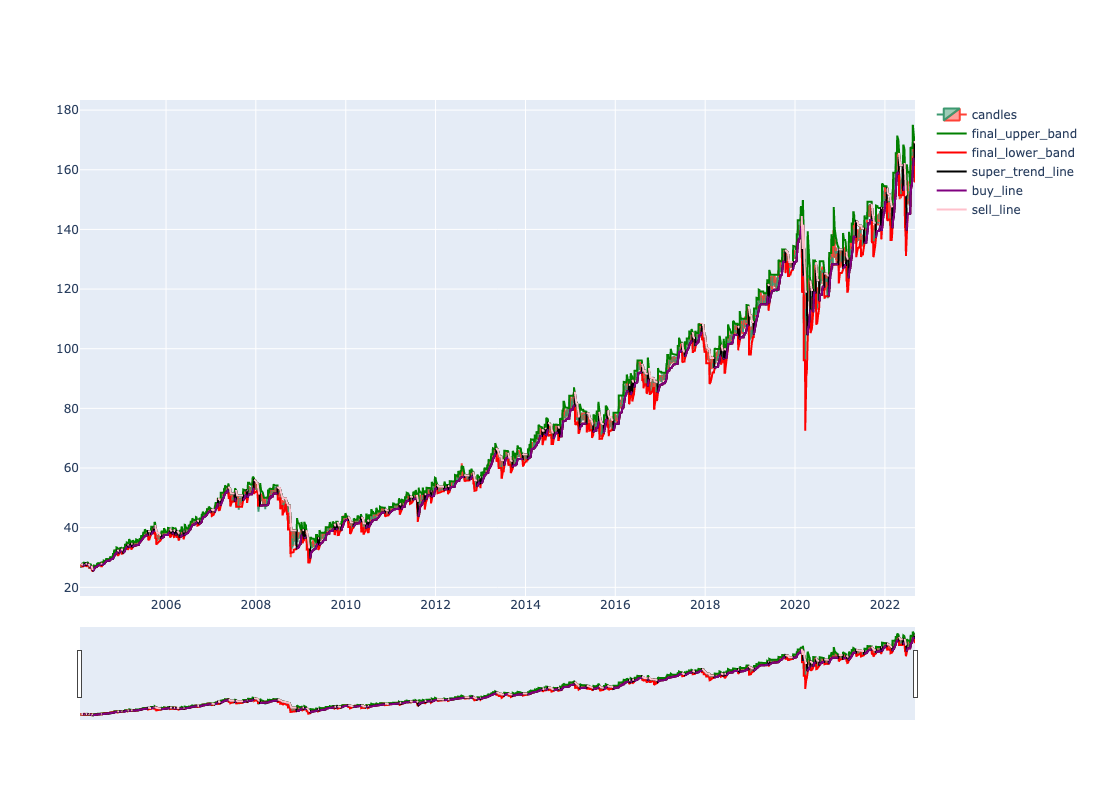

In [9]:
chart_super_trend(super_trend_df)

In [10]:
def simulate_portfolio_on_strategy(super_trend_df, initial_amt=10000):
    logs = []
    portfolio_vals = [initial_amt]
    percent_differences = [0.0]
    buying = False
    
    for i in range(1, len(super_trend_df.index)):
        current = i
        previous = i - 1
        current_trade = super_trend_df.iloc[current]['buy_or_sell']
        previous_trade = super_trend_df.iloc[previous]['buy_or_sell']
        
        # buy order
        if previous_trade == False and current_trade == True:
#             buy_price = super_trend_df.iloc[current]['Close']
            buying = True
            
        # sell order
        elif previous_trade == True and current_trade == False:
#             sell_price = super_trend_df.iloc[current]['Close']
#             percent_difference = (sell_price - buy_price) / buy_price
#             initial_amt = initial_amt * (1 + percent_difference)
            buying = False
            
        raw_percent_difference = 0
        if buying:
            previous_price = super_trend_df.iloc[previous]['Close']
            current_price = super_trend_df.iloc[current]['Close']
            raw_percent_difference = ((current_price - previous_price) / current_price)
        else:
            raw_percent_difference = 0
            
        percent_difference = 1 + raw_percent_difference
        initial_amt = initial_amt * percent_difference

        percent_differences.append(raw_percent_difference * 100)
        portfolio_vals.append(initial_amt)
            
    return portfolio_vals, percent_differences

In [11]:
INITIAL_AMOUNT = 1000
portfolio_over_time, percent_differences = simulate_portfolio_on_strategy(super_trend_df, INITIAL_AMOUNT)

super_trend_df['portfolio_values'] = portfolio_over_time
super_trend_df['percentage_change'] = percent_differences
# super_trend_df.head(len(super_trend_df.index))

In [12]:
def benchmark_strategy(super_trend_df, benchmark_ticker='VTI', initial_amt=INITIAL_AMOUNT):
    start_date = super_trend_df.iloc[0].name
    end_date = super_trend_df.iloc[-1].name
    print(f"start date: {start_date}")
    print(f"end date: {end_date}", "\n")

    # get benchmark data & calculate portfolio change by simply holding
    benchmark_df = yf.Ticker(benchmark_ticker).history(period="max")
    benchmark_df = benchmark_df[start_date:end_date]

    benchmark_percent_differences = [0.0]
    b_portfolio_values = [INITIAL_AMOUNT]

    for i in range(1, len(benchmark_df.index)):
        current = i
        previous = i - 1

        current_portfolio_value = benchmark_df.iloc[current]['Close']
        previous_portfolio_value = benchmark_df.iloc[previous]['Close']

        raw_percent_difference = (current_portfolio_value - previous_portfolio_value) / previous_portfolio_value
        percent_difference = 1 + raw_percent_difference

        b_previous_portfolio_value = b_portfolio_values[-1]
        b_portfolio_values.append(percent_difference * b_previous_portfolio_value)
        benchmark_percent_differences.append(raw_percent_difference * 100)
        
    benchmark_df['portfolio_values'] = b_portfolio_values
    benchmark_df['percentage_change'] = benchmark_percent_differences

    # get strategy principal & total values
    total_return = super_trend_df.loc[end_date]['portfolio_values']
    b_total_return = benchmark_df.loc[end_date]['portfolio_values']
    
    # get benchmark principal & total values
    principal = benchmark_df.loc[start_date]['portfolio_values']
    b_principal = benchmark_df.loc[start_date]['portfolio_values']

    # cumulative return
    cumulative_return = ((total_return - principal) / principal)
    cumulative_return = cumulative_return * 100

    # get benchmark cumulative return
    b_cumulative_return = ((b_total_return - b_principal) / b_principal)
    b_cumulative_return = b_cumulative_return * 100

    # annual return
    num_years_invested = int(((end_date - start_date).days) / 365)
    annual_return = ((total_return/principal) ** (1/num_years_invested)) - 1
    annual_return = annual_return * 100

    # benchmark annual return
    num_years_invested = int(((end_date - start_date).days) / 365)
    b_annual_return = ((b_total_return/b_principal) ** (1/num_years_invested)) - 1
    b_annual_return = b_annual_return * 100
    
    # annual volatility
    percent_differences = list(super_trend_df['percentage_change'].values)
    mean = sum(percent_differences) / len(percent_differences)
    variance = sum([((x - mean) ** 2) for x in percent_differences]) / len(percent_differences)
    volatility = variance ** 0.5

    # benchmark annual volatility    
    b_mean = sum(benchmark_percent_differences) / len(benchmark_percent_differences)
    b_variance = sum([((x - b_mean) ** 2) for x in benchmark_percent_differences]) / len(benchmark_percent_differences)
    b_volatility = b_variance ** 0.5
    
    # sharpe ratio
    treasury_rate = 3.5
    sharpe_ratio = (annual_return - treasury_rate) / variance

    # benchmark sharpe ratio
    b_sharpe_ratio = (b_annual_return - treasury_rate) / b_variance
    
    # calmar ratio
    portfolio_values = super_trend_df['portfolio_values'].values
    max_portfolio_val = max(portfolio_values)
    min_portfolio_val = min(portfolio_values)
    drawdown = (max_portfolio_val - min_portfolio_val) / (max_portfolio_val)
    calmar_ratio = (annual_return - treasury_rate) / drawdown

    # benchmark calmar ratio
    b_portfolio_values = benchmark_df['portfolio_values'].values
    b_max_portfolio_val = max(b_portfolio_values)
    b_min_portfolio_val = min(b_portfolio_values)
    b_drawdown = (b_max_portfolio_val - b_min_portfolio_val) / b_max_portfolio_val
    b_calmar_ratio = (b_annual_return - treasury_rate) / b_drawdown
    
    benchmark_comparison_dict = {
        'principal' : [INITIAL_AMOUNT, INITIAL_AMOUNT],
        'total_return' : [total_return, b_total_return],
        'cumulative_return' : [cumulative_return, b_cumulative_return],
        'annual_return': [annual_return, b_annual_return],
        'volatility': [volatility, b_volatility],
        'sharpe_ratio': [sharpe_ratio, b_sharpe_ratio],
        'calmar_ratio': [calmar_ratio, b_calmar_ratio]
    }

    # creating a Dataframe object from dictionary 
    # with custom indexing
    benchmark_comparison_df = pd.DataFrame(benchmark_comparison_dict, index = ['strategy', 'benchmark',])
    return benchmark_comparison_df, benchmark_df

In [13]:
benchmark_comparison_df, benchmark_df = benchmark_strategy(super_trend_df)
benchmark_comparison_df.head(5)

start date: 2004-02-02 00:00:00
end date: 2022-09-02 00:00:00 



principal  total_return  cumulative_return  annual_return  \
strategy        1000  14447.455020        1344.745502      15.993286   
benchmark       1000   5081.893862         408.189386       9.451985   

           volatility  sharpe_ratio  calmar_ratio  
strategy     0.712813     24.588121     13.398220  
benchmark    1.218450      4.009097      6.674707

In [14]:
def visualize_benchmark_against_strategy(super_trend_df, benchmark_df):
    benchmark_line = go.Line(
        name='benchmark_VTI',
        x=benchmark_df.index,
        y=benchmark_df['portfolio_values'],
        line=dict(color='red'),
    )

    strategy_line = go.Line(
        name=f'super_trend_strategy_{ticker}',
        x=super_trend_df.index,
        y=super_trend_df['portfolio_values'],
        line=dict(color='green'),
    )

    fig = go.Figure(
        data=[benchmark_line, strategy_line]
    )

    fig.update_layout(
        autosize=False,
        width=1200,
        height=800,)

    fig.show()

/Users/vaibhav/projects/super_trend/venv/lib/python3.9/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




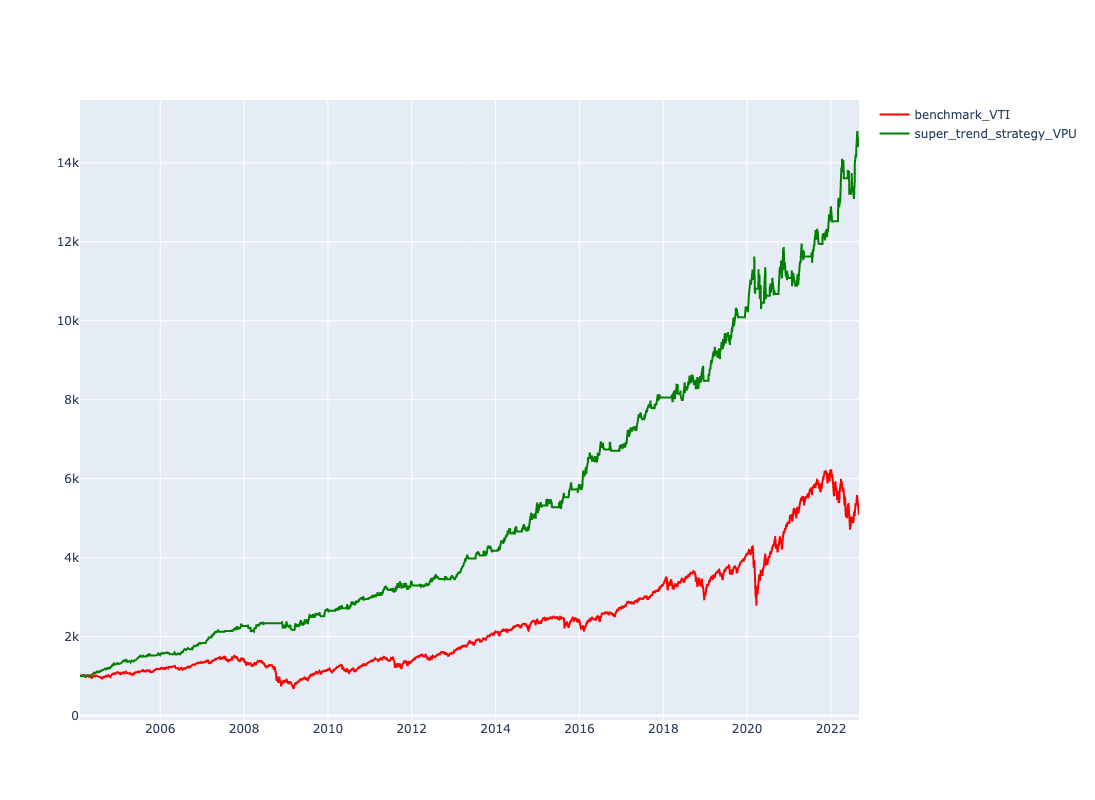

In [15]:
visualize_benchmark_against_strategy(super_trend_df, benchmark_df)